In [24]:
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

load_dotenv()

llm = init_chat_model("openai:gpt-4o-mini")

dumb_llm = init_chat_model("openai:gpt-5-nano")
average_llm = init_chat_model("openai:gpt-4.1-nano")
smart_llm = init_chat_model("openai:gpt-4o-mini")

In [25]:
class State(TypedDict):
    question: str
    diffriculty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["쉬움", "중간", "어려움"]

In [26]:
def dumb_node(state: State):
    response = dumb_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-5-nano",
    }


def average_node(state: State):
    response = average_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-4.1-nano",
    }


def smart_node(state: State):
    response = smart_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": "gpt-4o-mini",
    }


def assess_difficulty(state: State):
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(
        f"""
        이 질문의 난이도를 평가하세요.
        
        질문: {state["question"]}
        
        - 쉬움: 간단한 사실, 기본 정의, 예/아니오 대답에 해당.
        - 중간: 설명, 비교, 분석이 필요.
        - 어려움: 복잡한 추리, 여러 단계와 깊은 전문성이 필요.
        """
    )
    difficulty_level = response.difficulty_level

    if difficulty_level == "쉬움":
        goto = "dumb_node"
    elif difficulty_level == "중간":
        goto = "average_node"
    elif difficulty_level == "어려움":
        goto = "smart_node"

    return Command(
        goto=goto,
        update={
            "difficulty": difficulty_level,
        },
    )

In [27]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=(
        "dumb_node",
        "average_node",
        "smart_node",
    ),
)

graph_builder.add_edge(START, "assess_difficulty")


graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

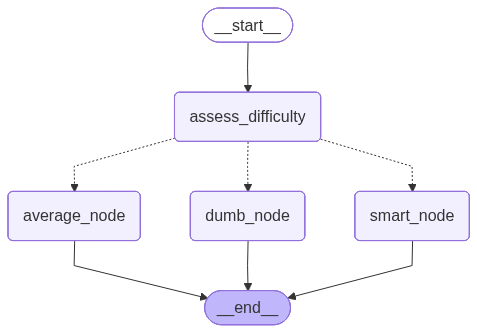

In [28]:
graph

In [30]:
graph.invoke(
    {
        "question": "2026년 우라늄의 투자 잠재력을 분석해줘.",
    }
)

{'question': '2026년 우라늄의 투자 잠재력을 분석해줘.',
 'answer': '2026년 우라늄의 투자 잠재력을 분석할 때는 여러 요소를 종합적으로 고려해야 합니다. 아래는 그 주요 요인과 전망입니다.\n\n1. 원자력 발전의 성장세\n- 글로벌 에너지 전환: 기후 변화 대응과 탈탄소 정책에 힘입어 원자력 발전소 건설 및 운영이 확대되고 있습니다.\n- 원자력의 안정적 에너지 공급 역할: 재생에너지의 간헐성 문제를 보완하는 안정적인 에너지원으로서 중요성이 높아지고 있습니다.\n2. 우라늄 시장의 수요와 공급\n- 수요 증가: 원자력 발전소 신규 건설과 가동률 향상으로 우라늄 수요가 지속 증가할 전망입니다.\n- 공급 제약: 주요 생산국(예: 카자흐스탄, 우즈베키스탄, 캐나다)의 정책 변화, 생산 중단 또는 감산 가능성은 공급 격차를 심화시킬 수 있습니다.\n3. 가격 전망\n- 우라늄 가격은 수요와 공급, 지정학적 리스크, 신규 공급처 개발 속도 등에 따라 변동 가능성이 큽니다.\n- 최근 몇 년간 가격이 저점에서 회복하는 조짐이 있으며, 2026년까지 공급 부족 우려와 높은 수요로 가격이 상승할 가능성이 있습니다.\n4. 기술 및 정책 요인\n- 원자력 기술 개발: 소형모듈원자로(SMR) 등 신기술 도입이 원자력 산업의 확대를 견인할 수 있습니다.\n- 정책적 지원: 여러 국가는 원자력 산업에 친환경 에너지로서 지원 정책을 강화하고 있어 수요에 긍정적 영향을 미칠 수 있습니다.\n5. 투자 리스크\n- 원자력 안전 문제와 방사능 폐기물 처리 문제,\n- 규제 강화와 정책 변화,\n- 글로벌 경제 상황의 변동이 투자의 불확실성을 높일 수 있습니다.\n요약하면, 2026년까지 우라늄의 투자 잠재력은 원자력 발전 수요 증가와 공급 제약 전망을 배경으로 상승 가능성이 크다고 볼 수 있습니다. 다만, 관련 리스크를 충분히 검토하고 시장 동향과 정책 변화를 지속적으로 모니터링하는 것이 중요합니다. 투자 결정 전 전문가 상담과 철저한 시장 조사도 권장됩니